<a href="https://colab.research.google.com/github/ccg-esb-lab/ARCfitness/blob/main/MonodGillespieARC_4_stability_expe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# In Silico Competition Experiments

This notebook performs the numerical experiments that quantify ARC stability under static and switching environments.  
Simulations begin with equal initial abundances of the reference and ARC-bearing strains and proceed through 100 consecutive 24-hour growth–dilution cycles.  
Three environmental regimes are implemented: constant aerobiosis, constant anaerobiosis, and single-switch transitions from anaerobiosis to aerobiosis after *K* days.  
Outputs include time-resolved abundances, final frequencies, and persistence indicators for all ARC families.


In [1]:
import os
import re
import time
import copy
import pickle
from dataclasses import dataclass

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.patches import Patch, Ellipse
from matplotlib.ticker import MultipleLocator
from numpy.linalg import lstsq

from pathlib import Path, Path as P
from pathlib import Path
from pathlib import Path

import uuid
import matplotlib.image as mpimg


plt.rcParams.update({
    "axes.labelsize": 16,   # fontsize for axis labels
    "xtick.labelsize": 14,  # fontsize for x-axis tick labels
    "ytick.labelsize": 14   # fontsize for y-axis tick labels
})

## Set experimental parameters

Model parameters:

In [2]:
initial_resource = 1.0
simulation_time = 24.0
B0=1e6
od2cells = 1e9

ref_family=''
ref_key='pMBA'

Simulation parameters:

In [3]:
#labels_of_interest = ["ereA2", "aacA7", "OXA10", "dfrA31","qacE","OXA1","OXA118","fosF", "BEL1", "GES1", "IMP2", "IMP31", "OXA129","OXA196", "VIM2", "VIM7", "dfrA6", "dfrB2", "aphA16", "aadB", "fosC2", "fosE", "fosG", "fosH", "fosI", "fosK", "fosL", "fosM", "fosN"]
labels_of_interest = ["ereA2", "aacA7", "OXA10", "dfrA31","qacE"]


families=['all','dfr', 'bla', 'aa', 'mix']
exportData=True
simulateData=True

n_syn = 1000

Ks = range(0,101, 5)
num_days = 100

E_color = "#B63E36"   # aerobiosis (anaerobiosis)
G_color = "#EBDD99"   # anaerobiosis (aerobiosis)

Ks_to_show = [25, 50, 75]

In [4]:
print(Ks[:])

range(0, 105, 5)


## Clone GitHub Repo

In [5]:


REPO=False


if REPO:
    
    repo_url = "https://github.com/ccg-esb-lab/ARCfitness.git"
    repo_name = "ARCfitness"
    
    if not Path(repo_name).exists():
        !git clone {repo_url}
    
    REPO_ROOT = Path(repo_name).resolve()
    print("Repo root:", REPO_ROOT)
    
    # Create local folders for figures and processed simulations.
    pathCODE = REPO_ROOT / "code/"
    pathFIGURES = REPO_ROOT / "figures/"
    pathSIM = REPO_ROOT / "sim/"
    
    pathFIGURES.mkdir(parents=True, exist_ok=True)
    pathSIM.mkdir(parents=True, exist_ok=True)



In [6]:
if not REPO:
    REPO_ROOT = Path("./").expanduser().resolve()
    
    if not REPO_ROOT.exists():
        raise FileNotFoundError(f"Repo not found at {REPO_ROOT}")
    
    print("Repo root:", REPO_ROOT)
    
    pathCODE    = REPO_ROOT / "code"
    pathFIGURES = REPO_ROOT / "figures"
    pathDATA    = REPO_ROOT / "data" 
    
    # Create output dirs if missing
    pathFIGURES.mkdir(parents=True, exist_ok=True)

    pathCODE    = str(REPO_ROOT / "code")    + "/"
    pathFIGURES = str(REPO_ROOT / "figures") + "/"
    pathDATA    = str(REPO_ROOT / "data")    + "/"
    
    print("pathCODE:", pathCODE)
    print("pathDATA:", pathDATA)
    print("pathFIGURES:", pathFIGURES)


Repo root: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness
pathCODE: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness/code/
pathDATA: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness/data/
pathFIGURES: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness/figures/


___

In [7]:
import sys, importlib, importlib.util

print("pathCODE =", pathCODE)
print("as str   =", str(pathCODE))

# Put code folder first (highest priority)
p = str(pathCODE)
if p in sys.path:
    sys.path.remove(p)
sys.path.insert(0, p)

# Force a clean import
sys.modules.pop("MonodGillespieMI", None)
sys.modules.pop("MonodGillespieMI_IO", None)

import MonodGillespieMI as MG
import MonodGillespieMI_IO as IO

print("\nLoaded MonodGillespieMI from:", MG.__file__)
print("Loaded MonodGillespieMI_IO from:", IO.__file__)


pathCODE = /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness/code/
as str   = /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness/code/

Loaded MonodGillespieMI from: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness/code/MonodGillespieMI.py
Loaded MonodGillespieMI_IO from: /Users/esb/Library/CloudStorage/GoogleDrive-rafael.penamiller@gmail.com/My Drive/SYNC_Projects/ARCfitness/FINAL/ARCfitness/code/MonodGillespieMI_IO.py


In [8]:
def _norm(s):
    return re.sub(r"[^a-z0-9]+", "", str(s).lower())


def load_exp_fitness_csv(csv_path):
    """
    Load experimental fitness from a CSV export.

    Parameters:
    - csv_path: path to a CSV with columns ARC and either mean, or replicate columns named as digits.

    Returns:
    - DataFrame with columns strain, w_exp, _key.
    """
    df = pd.read_csv(csv_path).dropna(how="all").dropna(axis=1, how="all")

    rep_cols = [c for c in df.columns if str(c).strip().isdigit()]

    if "mean" in df.columns:
        df["w_exp"] = pd.to_numeric(df["mean"], errors="coerce")
    else:
        df["w_exp"] = pd.to_numeric(df[rep_cols], errors="coerce").mean(axis=1)

    df = df.rename(columns={"ARC": "strain"}).dropna(subset=["strain", "w_exp"])
    df["_key"] = df["strain"].map(_norm)

    return df[["strain", "w_exp", "_key"]]


fitness_aero = load_exp_fitness_csv(REPO_ROOT / "data" / "ARC_fitness_aerobiosis.csv")
print(fitness_aero.head())

fitness_anaero = load_exp_fitness_csv(REPO_ROOT / "data" / "ARC_fitness_anaerobiosis.csv")
print(fitness_anaero.head())


   strain     w_exp    _key
0    VIM1  0.691702    vim1
1    VIM2  0.713427    vim2
2    OXA2  0.731454    oxa2
3  OXA118  0.733002  oxa118
4   IMP31  0.733117   imp31
   strain     w_exp    _key
0   dfrA1  0.931405   dfra1
1   dfrA5  0.965603   dfra5
2   dfrA6  0.910117   dfra6
3   dfrA7  0.858955   dfra7
4  dfrA12  0.937613  dfra12


## Simulate synthetic library

In [9]:


def sample_bivariate_w0(n, mu, cov, clip_min=None, clip_max=None, seed=None):
    """
    Draw n samples from N(mu, cov) and clip.
    """
    rng = np.random.default_rng(seed)
    samples = rng.multivariate_normal(mean=mu, cov=cov, size=n)
    if clip_min is not None or clip_max is not None:
        if clip_min is None: clip_min = -np.inf
        if clip_max is None: clip_max =  np.inf
        samples = np.clip(samples, clip_min, clip_max)
    return samples  # shape (n,2)


In [10]:



def _infer_time_col(columns):
    """Pick the time column using common labels; fallback to the first column."""
    candidates = [
        c for c in columns
        if re.search(r"^(time|t)\b", str(c).strip(), flags=re.I)
    ]
    return candidates[0] if candidates else columns[0]


def _to_numeric(df):
    """Coerce all columns to numeric (non-numeric values become NaN)."""
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df




In [11]:
def load_all_fits_csv(fits_csv, min_r2=0.9):
    df = pd.read_csv(fits_csv).dropna(how="all").dropna(axis=1, how="all")
    if df.empty:
        raise ValueError("No rows in fits CSV.")

    df["family"] = df["family"].astype("string")
    df["strain"] = df["strain"].astype("string")

    if "R2" in df.columns:
        df["R2"] = pd.to_numeric(df["R2"], errors="coerce")
        df = df[df["R2"] >= float(min_r2)]

    param_map = {}
    for _, r in df.iterrows():
        key = (str(r["family"]), str(r["strain"]))
        param_map[key] = {
            "Vmax": float(r["Vmax"]),
            "K": float(r["K"]),
            "c": float(r["c"]),
            "N0": float(r["N0_cells"]) if "N0_cells" in df.columns and pd.notna(r.get("N0_cells")) else 2e8,
            "R2": float(r["R2"]) if "R2" in df.columns and pd.notna(r.get("R2")) else float("nan"),
        }
    return df, param_map


## Run simulation

switch_K0    : E(100)   [100 days]
switch_K5    : G(5) E(95)   [100 days]
switch_K10   : G(10) E(90)   [100 days]
switch_K15   : G(15) E(85)   [100 days]
switch_K20   : G(20) E(80)   [100 days]
switch_K25   : G(25) E(75)   [100 days]
switch_K30   : G(30) E(70)   [100 days]
switch_K35   : G(35) E(65)   [100 days]
switch_K40   : G(40) E(60)   [100 days]
switch_K45   : G(45) E(55)   [100 days]
switch_K50   : G(50) E(50)   [100 days]
switch_K55   : G(55) E(45)   [100 days]
switch_K60   : G(60) E(40)   [100 days]
switch_K65   : G(65) E(35)   [100 days]
switch_K70   : G(70) E(30)   [100 days]
switch_K75   : G(75) E(25)   [100 days]
switch_K80   : G(80) E(20)   [100 days]
switch_K85   : G(85) E(15)   [100 days]
switch_K90   : G(90) E(10)   [100 days]
switch_K95   : G(95) E(5)   [100 days]
switch_K100  : G(100)   [100 days]
Loaded 114 fitted strains with R2 >= 0.9.
p0={'Vmax': 0.941251905423746, 'K': 1.9987089057549032, 'c': 1.0671426993446756e-09}

 Loading library for all

[all] loaded. Tota

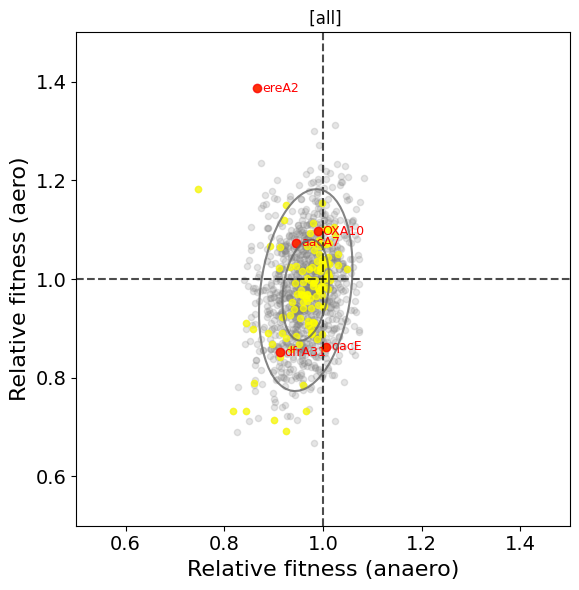

[skip] all / switch_K0 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K5 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K10 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K15 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K20 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K25 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K30 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K35 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K40 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K45 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K50 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K55 already in stability_pairs.csv. Skipping simulation.
[skip] all / switch_K60 already in stability_pairs.csv. Skipping simulation.
[

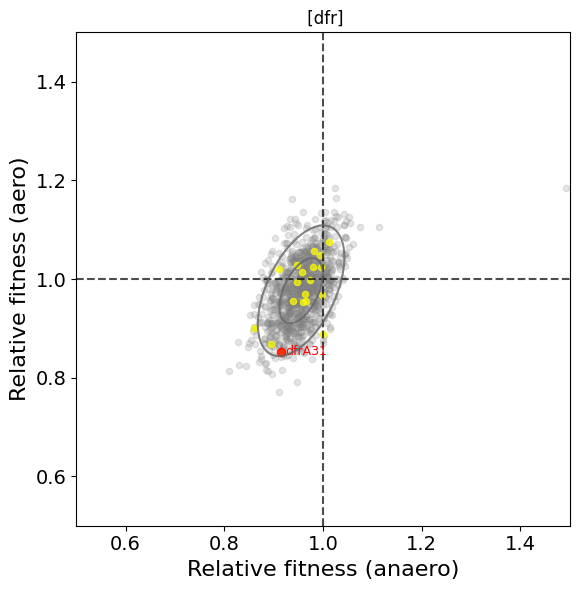

[skip] dfr / switch_K0 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K5 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K10 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K15 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K20 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K25 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K30 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K35 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K40 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K45 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K50 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K55 already in stability_pairs.csv. Skipping simulation.
[skip] dfr / switch_K60 already in stability_pairs.csv. Skipping simulation.
[

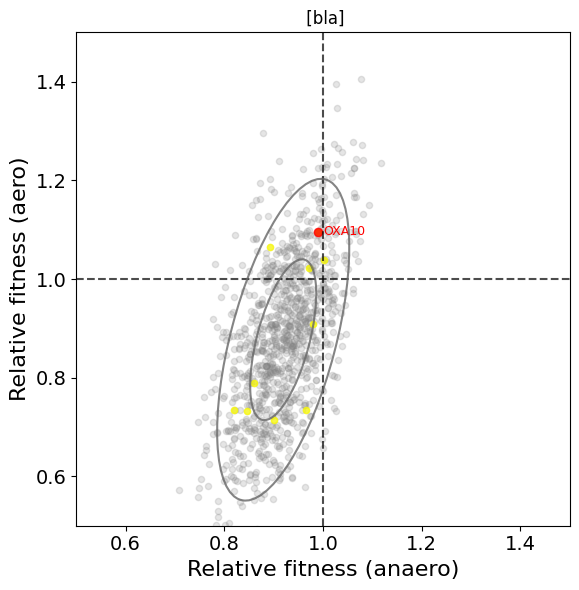

[skip] bla / switch_K0 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K5 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K10 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K15 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K20 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K25 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K30 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K35 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K40 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K45 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K50 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K55 already in stability_pairs.csv. Skipping simulation.
[skip] bla / switch_K60 already in stability_pairs.csv. Skipping simulation.
[

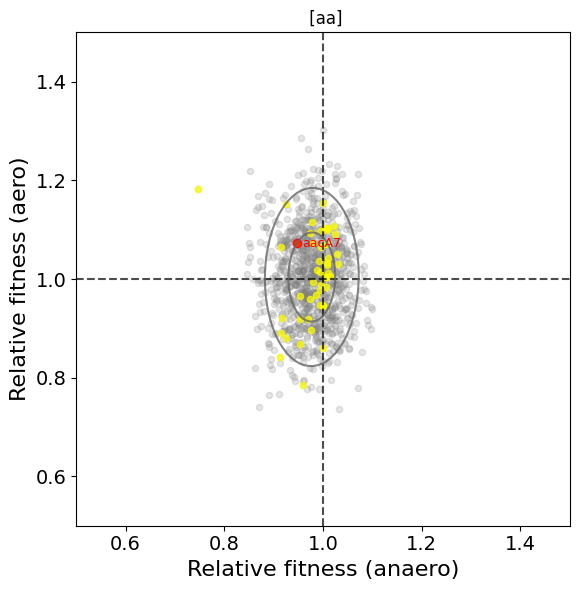

[skip] aa / switch_K0 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K5 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K10 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K15 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K20 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K25 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K30 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K35 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K40 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K45 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K50 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K55 already in stability_pairs.csv. Skipping simulation.
[skip] aa / switch_K60 already in stability_pairs.csv. Skipping simulation.
[skip] aa / sw

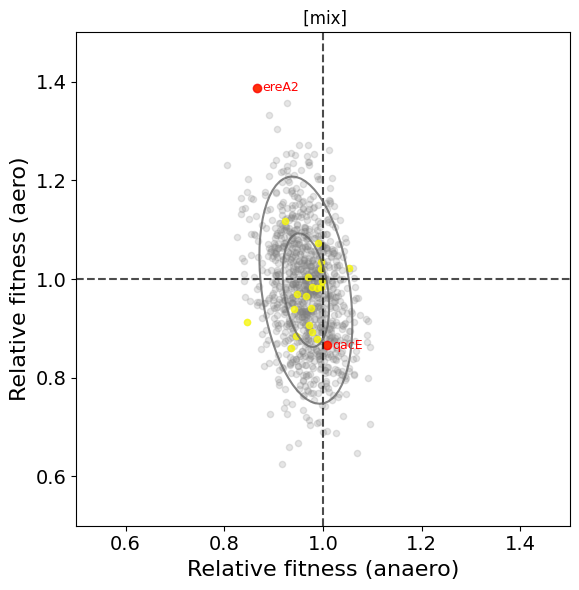

[skip] mix / switch_K0 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K5 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K10 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K15 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K20 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K25 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K30 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K35 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K40 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K45 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K50 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K55 already in stability_pairs.csv. Skipping simulation.
[skip] mix / switch_K60 already in stability_pairs.csv. Skipping simulation.
[

In [12]:

if simulateData:
    
    schedules_dict = MG.build_switch_schedules(Ks, num_days=num_days, first_env="G", second_env="E")
    MG.print_schedules_readable(schedules_dict)
    
    K_FIXED = 1.99647
    min_r2 = 0.9
    
    # Fits CSV (produced by your fitting pipeline)
    fits_csv = REPO_ROOT / "data" / "params_fits.csv"
    fits_df, PARAMS = load_all_fits_csv(REPO_ROOT / "data" / "params_fits.csv", min_r2=min_r2)
    
    print(f"Loaded {len(PARAMS)} fitted strains with R2 >= {min_r2}.")
    
    ref_key = ("", "pMBA")
    p0 = IO.get_params(fits_df, ref_key[0], ref_key[1])
    print(f"p0={p0}")
    
    p0_df = pd.DataFrame(
        {
            "Vmax": [p0["Vmax"], p0["Vmax"]],
            "K": [p0["K"], p0["K"]],
            "c": [p0["c"], p0["c"]],
        },
        index=["E", "G"],
    )
    
    
    for fam in families:
        print("\n===============================")
        print(f" Loading library for {fam}")
        print("===============================\n")
    
        fitness_csv = REPO_ROOT / "data" / f"fitness_{fam}.csv"
        df_env_bivar = (
            pd.read_csv(fitness_csv)
            .dropna(how="all")
            .dropna(axis=1, how="all")
        )
    
        if "family" in df_env_bivar.columns:
            df_env_bivar = df_env_bivar[df_env_bivar["family"] == fam].reset_index(drop=True)
        else:
            df_env_bivar["family"] = fam
    
        print(f"[{fam}] loaded. Total rows: {len(df_env_bivar)}")
    
        stability_agg_csv = REPO_ROOT / "data" / "stability_aggregates.csv"
        stability_pairs_csv = REPO_ROOT / "data" / "stability_pairs.csv"
    
        # Load previously simulated (family, schedule_name) pairs
        if stability_pairs_csv.exists():
            df_pairs_prev = (
                pd.read_csv(stability_pairs_csv)
                .dropna(how="all")
                .dropna(axis=1, how="all")
            )
            if {"family", "schedule_name"}.issubset(df_pairs_prev.columns):
                already_done = set(
                    zip(df_pairs_prev["family"].astype(str), df_pairs_prev["schedule_name"].astype(str))
                )
            else:
                already_done = set()
        else:
            df_pairs_prev = pd.DataFrame()
            already_done = set()

        print("\nFamily:", fam)

        bundles = {}
        run_id = str(uuid.uuid4())

        # Load fitness library for this family
        fitness_csv = REPO_ROOT / "data" / f"fitness_{fam}.csv"
        df_env = (
            pd.read_csv(fitness_csv)
            .dropna(how="all")
            .dropna(axis=1, how="all")
        )

        if "family" in df_env.columns and fam != "all":
            df_env = df_env[df_env["family"] == fam].reset_index(drop=True)
        else:
            df_env = df_env.reset_index(drop=True)

        print(f"[{fam}] df_env shape:", df_env.shape)

        df_strains = df_env[~df_env["label"].astype(str).str.contains("_x", na=False)].reset_index(drop=True)
        df_env_bivar = df_env.copy()

        MG._validate_params(df_env_bivar)

        all_pairs = sorted(df_env_bivar["pair_idx"].unique().tolist())
        print(f"[{fam}] n_pairs in library:", len(all_pairs))

        # Experimental strains = labels that do NOT start with 'x_'
        highlight_labels = (
            df_env_bivar.loc[
                ~df_env_bivar["label"].astype(str).str.startswith("x_"),
                "label"
            ]
            .unique()
            .tolist()
        )


        MG.plot_w_scatter(
            df_env_bivar,
            family=fam,
            highlight=highlight_labels,
            annotate=labels_of_interest,
            ellipse_mode="rotated",
            pathFIGURES=pathFIGURES,
        )

        for sched_name, schedule in schedules_dict.items():
            if (fam, sched_name) in already_done:
                print(f"[skip] {fam} / {sched_name} already in stability_pairs.csv. Skipping simulation.")
                continue

            sched_str = "".join(schedule)
            print(f"\nSchedule: {fam} / {sched_name} : {sched_str}")

            bundle = MG.analyze_schedule_population(
                df_strains=df_env_bivar,
                labels_of_interest=labels_of_interest,
                df_env=df_env_bivar,
                pair_indices=all_pairs,
                schedule=schedule,
                p0=p0,
                sim_fn=MG.gillespie_bacterial_growth_batch,
                initial_resource=initial_resource,
                day_hours=24.0,
                dilution=100.0,
                Ntot0_start=1e6,
                freqA0_start=0.5,
                outcome_thresholds=(0.1, 0.9),
                toPlot=True,
                title=f"{fam}_{sched_name}",
                family=fam,
                pathFIGURES=pathFIGURES,
            )

            bundles[sched_name] = bundle

            print(f"Pairs analyzed: {bundle['agg']['n_pairs']}")
            print(f"Persistence (end): {bundle['agg']['P_end']:.2f}")

            agg_row = pd.DataFrame([{
                "run_id": run_id,
                "family": fam,
                "num_days": num_days,
                "schedule_name": sched_name,
                "schedule_str": sched_str,
                "n_pairs": bundle["agg"]["n_pairs"],
                "P_end": bundle["agg"]["P_end"],
                "n_cleared": bundle["outcome_counts"].get("cleared", 0),
                "n_stable": bundle["outcome_counts"].get("stable", 0),
                "n_fixated": bundle["outcome_counts"].get("fixated", 0),
                "frac_cleared": bundle["outcome_frac"].get("cleared", float("nan")),
                "frac_stable": bundle["outcome_frac"].get("stable", float("nan")),
                "frac_fixated": bundle["outcome_frac"].get("fixated", float("nan")),
            }])

            df_pairs_sched = bundle["pair_stats"].copy()
            df_pairs_sched["run_id"] = run_id
            df_pairs_sched["family"] = fam
            df_pairs_sched["schedule_name"] = sched_name
            df_pairs_sched["schedule_str"] = sched_str

            if "label" in df_env_bivar.columns:
                df_labels = df_env_bivar[["pair_idx", "label"]].drop_duplicates(subset=["pair_idx"]).copy()
                df_labels["label"] = df_labels["label"].fillna(df_labels["pair_idx"].apply(lambda x: f"x_{x}"))
                df_pairs_sched = df_pairs_sched.merge(df_labels, on="pair_idx", how="left")
            else:
                df_pairs_sched["label"] = df_pairs_sched["pair_idx"].apply(lambda x: f"x_{x}")

            if exportData:
                # Append aggregates
                if stability_agg_csv.exists():
                    df_agg_prev = pd.read_csv(stability_agg_csv).dropna(how="all").dropna(axis=1, how="all")
                    df_agg_out = pd.concat([df_agg_prev, agg_row], ignore_index=True)
                else:
                    df_agg_out = agg_row

                # De-duplicate by (family, schedule_name): keep last
                if {"family", "schedule_name"}.issubset(df_agg_out.columns):
                    df_agg_out = df_agg_out.drop_duplicates(subset=["family", "schedule_name"], keep="last")

                df_agg_out.to_csv(stability_agg_csv, index=False)

                # Append per-pair stats
                if stability_pairs_csv.exists():
                    df_pairs_prev = pd.read_csv(stability_pairs_csv).dropna(how="all").dropna(axis=1, how="all")
                    df_pairs_out = pd.concat([df_pairs_prev, df_pairs_sched], ignore_index=True)
                else:
                    df_pairs_out = df_pairs_sched

                # De-duplicate by (family, schedule_name, pair_idx): keep last
                key_cols = ["family", "schedule_name", "pair_idx"]
                if set(key_cols).issubset(df_pairs_out.columns):
                    df_pairs_out = df_pairs_out.drop_duplicates(subset=key_cols, keep="last")

                df_pairs_out.to_csv(stability_pairs_csv, index=False)

        if not bundles:
            print(f"[info] No new schedules simulated for {fam}")
